This notebook is only intended for plotting the required diagrams in problem 2. All code solutions are in the common `.py` files as well.

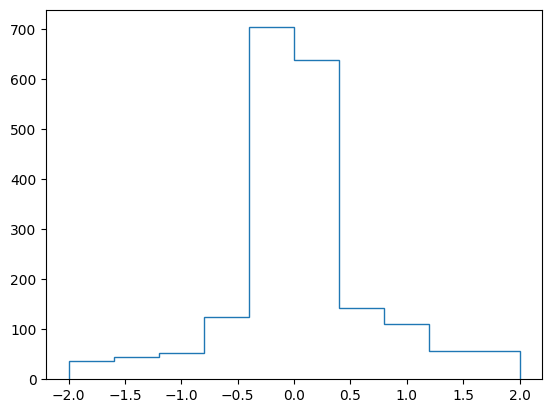

In [2]:
import numpy as np
import trimesh
from utils import path_
from sklearn.neighbors import KDTree as sklearn_KDTree
from sklearn.decomposition import PCA as sklearn_PCA

# Problem 2.1, use trimesh to implement naive sample
def uniform_sample(mesh: trimesh.Trimesh, cnt: int) -> np.ndarray:
    import trimesh.sample
    return np.asarray(trimesh.sample.sample_surface(mesh=mesh, count=cnt)[0])

# Problem 2.2, my implementation of farthest point sampling
def farthest_point_sampling(pts: np.ndarray, cnt: int, return_index=False) -> np.ndarray:
    assert len(pts) > cnt

    # points that are not yet selected, note as {x}
    pts_index = np.arange(len(pts))

    # points selected, note as S
    ret = []

    # note as D, D(x)=sum_{s in S}|s-x|_2
    dist = np.zeros_like(pts_index, dtype=np.float32)

    # random pick a start point
    initial_pt = np.random.choice(pts_index)
    ret.append(pts_index[initial_pt])
    pts_index = np.delete(pts_index, initial_pt)

    for _ in range(cnt - 1):
        # update the distance record
        dist[pts_index] += np.sum(np.square(pts[ret[-1]] - pts[pts_index]), axis=-1)
        # select the farthest one
        pt_to_be_added = np.argmax(dist[pts_index])
        ret.append(pts_index[pt_to_be_added])
        pts_index = np.delete(pts_index, pt_to_be_added)

    if return_index:
        return pts[ret], ret

    return pts[ret]

# Problem 2.3, normal estimation using PCA from sklearn
def normal_estimation(idx: np.ndarray, all_pts: np.ndarray, neighbor_cnt=50) -> np.ndarray:

    pts = all_pts[idx]
    tree = sklearn_KDTree(all_pts, leaf_size=10) 
    dist, ind = tree.query(pts, k=neighbor_cnt)
    neighbor_pts = all_pts[ind]
    centers = neighbor_pts.sum(axis=1) / neighbor_cnt
    Y = neighbor_pts - centers[:,np.newaxis,:]
    pca = sklearn_PCA(n_components=3)

    normal = []
    for i in range(len(Y)):
        pca.fit(Y[i])
        normal.append(pca.components_[-1])

    return np.asarray(normal)

# Problem 3.4 curvature estimation
def curvature_estimation(mesh: trimesh.Trimesh, plot_result=False):
    # regenetate vertex normals because original vertex normal is bad
    mesh= trimesh.Trimesh(vertices=mesh.vertices, faces=mesh.faces)
    
    faces = mesh.vertices[mesh.faces]
    faces_vertices_normals = mesh.vertex_normals[mesh.faces]
    centers, normals = trimesh.points.plane_fit(faces)
    sqrt2=np.sqrt(2)
    # df=np.array([[1.,0.],[0.,1./sqrt2],[0.,1./sqrt2]])
    curvature = []
    real_curvatures = []
    complex_curvatures =[]
    gaussian_curvatures = []
    for face_idx in range(len(faces)):
        
        P=faces[face_idx]
        N=faces_vertices_normals[face_idx]
        center = centers[face_idx]
        normal = normals[face_idx]
        df = np.vstack([P[1]-P[0], np.cross(P[1]-P[0], normal)]).T
        deltaP=np.asarray([P[2]-P[1], P[0]-P[2], P[1]-P[0]]).T
        deltaN=np.asarray([N[2]-N[1], N[0]-N[2], N[1]-N[0]]).T
        # transpose both side to get into the form Ax=B
        # and split the column of S.T (rows of S) to be able to use np.linalg.lstsq 
        A= (df.T @ deltaP.T).T
        B= (df.T @ deltaN).T
        S_T_col1, _, _, _ = np.linalg.lstsq(A, B[:,0], rcond=None)
        S_T_col2, _, _, _ = np.linalg.lstsq(A, B[:,1], rcond=None)
        S = np.vstack([S_T_col1, S_T_col2])
        cur_curvature = np.linalg.eigvals(S)

        if np.iscomplex(cur_curvature).any():
            # print(cur_curvature) # how to solve that
            complex_curvatures.append(cur_curvature)
            gaussian_curvatures.append(np.linalg.norm(cur_curvature[0]*cur_curvature[1]))
        else:
            real_curvatures.append(cur_curvature)
            gaussian_curvatures.append(cur_curvature[0]*cur_curvature[1])

    curvature.append(np.linalg.eigvals(S))
    real_curvatures=np.asarray(real_curvatures)
    complex_curvatures=np.asarray(complex_curvatures)
    curvature = np.asarray(curvature)
    gaussian_curvatures=np.asarray(gaussian_curvatures)

    if plot_result:
        import matplotlib.pyplot as plt


        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        print(max(real_curvatures[0]))
        hist, xedges, yedges = np.histogram2d(real_curvatures[:,0], real_curvatures[:,1], bins=30, range=[[0, 15], [0, 15]])
        xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
        xpos = xpos.ravel()
        ypos = ypos.ravel()
        zpos = 0
        dx = dy = 0.5 * np.ones_like(zpos)
        dz = hist.ravel()

        ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
        counts, bins = np.histogram(gaussian_curvatures)
        plt.stairs(counts, bins)

        plt.show()
    
# Problem 3.4 curvature estimation
def curvature_point_estimation(pts: np.ndarray, normals: np.ndarray, plot_result=True):
    tree = sklearn_KDTree(pts, leaf_size=2)
    dist, ind = tree.query(pts, k=3)
    neighbors = pts[ind]
    neighbor_normals = normals[ind]

    sqrt2=np.sqrt(2)
    # df=np.array([[1.,0.],[0.,1./sqrt2],[0.,1./sqrt2]])
    curvature = []
    real_curvatures = []
    complex_curvatures =[]
    gaussian_curvatures = []
    for pt_index in range(len(pts)):
        P= neighbors[pt_index]
        N= neighbor_normals[pt_index]
        _, normal = trimesh.points.plane_fit(neighbors[pt_index])
        df = np.vstack([P[1]-P[0], np.cross(P[1]-P[0], normal)]).T
        deltaP=np.asarray([P[2]-P[1], P[0]-P[2], P[1]-P[0]]).T
        deltaN=np.asarray([N[2]-N[1], N[0]-N[2], N[1]-N[0]]).T
        # transpose both side to get into the form Ax=B
        # and split the column of S.T (rows of S) to be able to use np.linalg.lstsq 
        A= (df.T @ deltaP.T).T
        B= (df.T @ deltaN).T
        S_T_col1, _, _, _ = np.linalg.lstsq(A, B[:,0], rcond=None)
        S_T_col2, _, _, _ = np.linalg.lstsq(A, B[:,1], rcond=None)
        S = np.vstack([S_T_col1, S_T_col2])
        cur_curvature = np.linalg.eigvals(S)

        if np.iscomplex(cur_curvature).any():
            # print(cur_curvature) # how to solve that
            complex_curvatures.append(cur_curvature)
            gaussian_curvatures.append(np.linalg.norm(cur_curvature[0]*cur_curvature[1]))
        else:
            real_curvatures.append(cur_curvature)
            gaussian_curvatures.append(cur_curvature[0]*cur_curvature[1])

    curvature.append(np.linalg.eigvals(S))
    real_curvatures=np.asarray(real_curvatures)
    complex_curvatures=np.asarray(complex_curvatures)
    curvature = np.asarray(curvature)
    gaussian_curvatures=np.asarray(gaussian_curvatures)
    if plot_result:
        import matplotlib.pyplot as plt
        fig = plt.figure()
        counts, bins = np.histogram(gaussian_curvatures, range=(-2,2))
        plt.stairs(counts, bins)

        plt.show()

def main():
    saddle = trimesh.load_mesh(path_("saddle.obj"))
    pts_100k = uniform_sample(saddle, 100000)
    pts_4k, idx = farthest_point_sampling(pts_100k, 4000, return_index=True)

    normals = normal_estimation(idx, pts_100k)
    curvature_point_estimation(pts_4k, normals)
    # icosphere=trimesh.load_mesh(path_("icosphere.obj"))
    # sievert = trimesh.load_mesh(path_("sievert.obj"))

    # curvature_estimation(icosphere)
    # curvature_estimation(sievert)


if __name__ == "__main__":
    main()
